<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import datetime
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
from collections import Counter
from collections import Counter, defaultdict
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy


import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import datetime
import joblib
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")

df_train = df[:70000]
df_test = df[70000:100000]
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df_train['question1'] = df_train['question1'].apply(lambda x: str(x))
df_train['question2'] = df_train['question2'].apply(lambda x: str(x))

df_test['question1'] = df_test['question1'].apply(lambda x: str(x))
df_test['question2'] = df_test['question2'].apply(lambda x: str(x))

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

startTime3 = datetime.datetime.now()
print("Current Time = ",startTime3)

# merge texts
questions_train = list(df_train['question1']) + list(df_train['question2']) 
questions_test = list(df_test['question1']) + list(df_test['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions_train)
tfidf.transform(questions_test)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

print("Time taken to run this cell {}".format(datetime.datetime.now() - startTime3))

Current Time =  2019-05-16 14:38:05.153887
Time taken to run this cell 0:00:11.290700


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [7]:
print(np.shape(df_train['question1']))

(70000,)


In [8]:
# vectorizing train data of question1
# last comment worked: https://stackoverflow.com/questions/49964028/spacy-oserror-cant-find-model-en

startTime3 = datetime.datetime.now()
print("Current Time = ",startTime3)

# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(df_train['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

df_train['q1_feats_m_train'] = list(vecs1)

print("Time taken to run this cell {}".format(datetime.datetime.now() - startTime3))

Current Time =  2019-05-16 14:44:37.209707


100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [55:24<00:00, 21.05it/s]


Time taken to run this cell 0:55:27.805032


In [10]:
# vectorizing train data of question2

startTime3 = datetime.datetime.now()
print("Current Time = ",startTime3)

vecs2 = []
for qu2 in tqdm(df_train['question2']):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

df_train['q2_feats_m_train'] = list(vecs2)

print("Time taken to run this cell {}".format(datetime.datetime.now() - startTime3))

Current Time =  2019-05-16 15:41:58.087603


100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [54:53<00:00, 21.26it/s]


Time taken to run this cell 0:54:53.656920


In [11]:
# vectorizing test data of question1

startTime3 = datetime.datetime.now()
print("Current Time = ",startTime3)

# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(df_test['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

df_test['q1_feats_m_test'] = list(vecs1)

print("Time taken to run this cell {}".format(datetime.datetime.now() - startTime3))

Current Time =  2019-05-16 16:36:51.773923


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [29:00<00:00, 14.91it/s]


Time taken to run this cell 0:29:03.005378


In [12]:
# vectorizing test data of question2

startTime3 = datetime.datetime.now()
print("Current Time = ",startTime3)

vecs2 = []
for qu2 in tqdm(df_test['question2']):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

df_test['q2_feats_m_test'] = list(vecs2)

print("Time taken to run this cell {}".format(datetime.datetime.now() - startTime3))

Current Time =  2019-05-16 17:05:54.822112


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [28:58<00:00, 17.25it/s]


Time taken to run this cell 0:28:59.068028


In [29]:
startTime = datetime.datetime.now()
print("Current Time = ",startTime)

ques_1_train_df = pd.DataFrame(df_train['q1_feats_m_train'].tolist())
ques_1_test_df = pd.DataFrame(df_train['q2_feats_m_train'].tolist())

ques_2_train_df = pd.DataFrame(df_test['q1_feats_m_test'].tolist())
ques_2_test_df = pd.DataFrame(df_test['q2_feats_m_test'].tolist())

print("Time taken to run this cell {}".format(datetime.datetime.now() - startTime))

Current Time =  2019-05-16 17:43:40.710343
Time taken to run this cell 0:01:31.432278


In [13]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [14]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [17]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [20]:
df1_train = df1[:70000]
df1_test = df1[70000:100000]
df1_test[:10]

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
70000,70000,1,0.666644,0.666644,0.999967,0.599988,0.833319,0.624992,0.0,1.0,2.0,7.0,90,90,68,76,0.411765
70001,70001,0,0.399992,0.249997,0.000000,0.000000,0.153845,0.133332,0.0,0.0,2.0,14.0,64,61,41,42,0.220779
70002,70002,0,0.666644,0.499988,0.666644,0.499988,0.571420,0.571420,0.0,0.0,0.0,7.0,77,72,70,68,0.615385
70003,70003,0,0.999967,0.749981,0.999975,0.799984,0.999986,0.777769,0.0,1.0,2.0,8.0,100,87,87,100,0.972222
70004,70004,0,0.249997,0.249997,0.142855,0.083333,0.187499,0.124999,0.0,0.0,8.0,20.0,58,49,52,53,0.122642
70005,70005,0,0.499988,0.499988,0.499975,0.199996,0.499992,0.333330,0.0,0.0,3.0,7.5,69,69,60,76,0.384615
70006,70006,1,0.999967,0.749981,0.666644,0.666644,0.833319,0.714276,0.0,0.0,1.0,6.5,92,86,86,91,0.857143
70007,70007,1,0.666656,0.571420,0.749981,0.599988,0.699993,0.583328,1.0,1.0,2.0,11.0,83,67,75,70,0.403509
70008,70008,0,0.000000,0.000000,0.666644,0.249997,0.249997,0.142856,0.0,0.0,6.0,11.0,43,41,37,43,0.170213
70009,70009,0,0.999967,0.999967,0.599988,0.374995,0.749991,0.461535,1.0,0.0,5.0,10.5,84,68,70,75,0.682927


In [21]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [22]:
df2_train = df2[:70000]
df2_test = df2[70000:100000]
df2_test[:10]

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
70000,70000,1,1,40,33,8,6,4.0,14.0,0.285714,2,0
70001,70001,1,1,77,76,12,14,1.0,25.0,0.040000,2,0
70002,70002,1,1,44,38,7,7,4.0,14.0,0.285714,2,0
70003,70003,1,1,45,35,8,6,5.0,14.0,0.357143,2,0
70004,70004,4,1,105,116,15,22,3.0,34.0,0.088235,5,3
70005,70005,1,1,47,38,9,6,2.0,15.0,0.133333,2,0
70006,70006,2,1,40,34,7,6,4.0,13.0,0.307692,3,1
70007,70007,1,1,56,69,10,12,7.0,22.0,0.318182,2,0
70008,70008,1,1,46,75,8,14,2.0,22.0,0.090909,2,0
70009,70009,1,1,54,40,12,8,6.0,19.0,0.315789,2,0


In [24]:
# dataframe of nlp features
df3.head()

,id
0,0
1,1
2,2
3,3
4,4


In [25]:
df3_train = df3[:70000]
df3_test = df3[70000:100000]
df3_test[:10]

,id
70000,70000
70001,70001
70002,70002
70003,70003
70004,70004
70005,70005
70006,70006
70007,70007
70008,70008
70009,70009


In [30]:
df3_q1_train = pd.DataFrame(ques_1_train_df, index= df3_train.index)
df3_q1_test = pd.DataFrame(ques_1_test_df, index= df3_test.index)

df3_q2_train = pd.DataFrame(ques_2_train_df, index= df3_train.index)
df3_q2_test = pd.DataFrame(ques_2_test_df, index= df3_test.index)

In [32]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", ques_1_train_df.shape[1])
print("Number of features in question2 w2v  dataframe :", ques_1_test_df.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+ques_1_train_df.shape[1]+ques_1_test_df.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 384
Number of features in question2 w2v  dataframe : 384
Number of features in final dataframe  : 797


In [33]:
# storing the final features of train data to csv file
startTime3 = datetime.datetime.now()
print("Current Time = ",startTime3)

if not os.path.isfile('final_features_train_w2v.csv'):
    df3_q1_train['id']=df1_train['id']
    df3_q2_train['id']=df1_train['id']
    df1_train  = df1_train.merge(df2_train, on='id',how='left')
    df2_train  = df3_q1_train.merge(df3_q2_train, on='id',how='left')
    result  = df1_train.merge(df2_train, on='id',how='left')
    result.to_csv('final_features_train_w2v.csv')
    
print("Time taken to run this cell {}".format(datetime.datetime.now() - startTime3))

Current Time =  2019-05-16 17:47:45.417730
Time taken to run this cell 0:06:12.196241


In [34]:
final_features_train_w2v = pd.read_csv("final_features_train_w2v.csv")
final_features_train_w2v[:5]

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,-1.913172,9.452115,7.700348,-8.207552,7.190231,2.800261,-4.557190,0.837903,8.546584,6.314993
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,8.734211,27.826567,13.032731,-6.930430,3.324043,0.948788,-23.472008,3.298593,28.678169,9.660554
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,-18.384814,3.862209,16.417156,-3.425271,-12.746041,-3.043191,-4.743920,12.397037,-0.398171,-13.135662
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,10.311258,12.988016,0.664790,-4.728610,10.399462,5.935001,-4.696811,2.790680,20.241084,-5.227907
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,16.638970,-1.372965,-0.314083,-22.204033,5.011401,15.180408,-10.172982,15.786889,2.275847,2.753095


In [35]:
# storing the final features of test data to csv file
startTime = datetime.datetime.now()
print("Current Time = ",startTime)

if not os.path.isfile('final_features_test_w2v.csv'):
    df3_q1_test['id']=df1_test['id']
    df3_q2_test['id']=df1_test['id']
    df1_test  = df1_test.merge(df2_test, on='id',how='left')
    df2_test  = df3_q1_test.merge(df3_q2_test, on='id',how='left')
    result_test  = df1_test.merge(df2_test, on='id',how='left')
    result_test.to_csv('final_features_test_w2v.csv')
    
print("Time taken to run this cell {}".format(datetime.datetime.now() - startTime))

Current Time =  2019-05-16 17:58:22.846895
Time taken to run this cell 0:01:15.298492


In [36]:
final_features_test_w2v = pd.read_csv("final_features_test_w2v.csv")
final_features_test_w2v[:5]

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,70000,1,0.666644,0.666644,0.999967,0.599988,0.833319,0.624992,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,70001,0,0.399992,0.249997,0.000000,0.000000,0.153845,0.133332,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,70002,0,0.666644,0.499988,0.666644,0.499988,0.571420,0.571420,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,70003,0,0.999967,0.749981,0.999975,0.799984,0.999986,0.777769,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,70004,0,0.249997,0.249997,0.142855,0.083333,0.187499,0.124999,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# remove the first row 
start = datetime.datetime.now()
print("Current Time = ",start)

final_features_train_w2v.drop(final_features_train_w2v.index[0], inplace=True)
y_true_train = final_features_train_w2v['is_duplicate']
final_features_train_w2v.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

final_features_test_w2v.drop(final_features_test_w2v.index[0], inplace=True)
y_true_test = final_features_test_w2v['is_duplicate']
final_features_test_w2v.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start)

Current Time =  2019-05-16 17:59:46.116073
Time taken to run this cell:  0:00:03.002798


In [38]:
final_features_train_w2v.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,8.734211,27.826567,13.032731,-6.930430,3.324043,0.948788,-23.472008,3.298593,28.678169,9.660554
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,-18.384814,3.862209,16.417156,-3.425271,-12.746041,-3.043191,-4.743920,12.397037,-0.398171,-13.135662
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,10.311258,12.988016,0.664790,-4.728610,10.399462,5.935001,-4.696811,2.790680,20.241084,-5.227907
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,16.638970,-1.372965,-0.314083,-22.204033,5.011401,15.180408,-10.172982,15.786889,2.275847,2.753095
5,0.666656,0.571420,0.888879,0.799992,0.705878,0.705878,1.0,0.0,0.0,17.0,...,7.850638,2.975380,9.910241,0.588800,-5.671324,9.163055,-7.469239,4.996450,8.493940,2.154523


In [39]:
final_features_test_w2v.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.399992,0.249997,0.000000,0.000000,0.153845,0.133332,0.0,0.0,2.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.666644,0.499988,0.666644,0.499988,0.571420,0.571420,0.0,0.0,0.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.999967,0.749981,0.999975,0.799984,0.999986,0.777769,0.0,1.0,2.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.249997,0.249997,0.142855,0.083333,0.187499,0.124999,0.0,0.0,8.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.499988,0.499988,0.499975,0.199996,0.499992,0.333330,0.0,0.0,3.0,7.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# resetting index
def reset_index(data_frame):
    data_frame = data_frame.reset_index()
    data_frame['index_col'] = data_frame.index

    data_frame = data_frame.drop("index", axis=1)
    data_frame = data_frame.drop("index_col", axis=1)
    return(data_frame)

In [ ]:
final_features_train_w2v = reset_index(final_features_train_w2v)
final_features_test_w2v = reset_index(final_features_test_w2v)

In [40]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true_train = list(map(int, y_true_train.values))
y_true_test = list(map(int, y_true_test.values))

In [41]:
print(np.shape(y_true_train))
print(np.shape(y_true_test))

(69999,)
(29999,)


<h2> Converting strings to numerics </h2>

In [42]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model

start = datetime.datetime.now()
print("Current Time = ",start)

cols = list(final_features_train_w2v.columns)
for i in cols:
    final_features_train_w2v[i] = final_features_train_w2v[i].apply(pd.to_numeric)
    print(i)
    
current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start)

start2 = datetime.datetime.now()
print("Current Time = ",start2)
    
cols = list(final_features_test_w2v.columns)
for i in cols:
    final_features_test_w2v[i] = final_features_test_w2v[i].apply(pd.to_numeric)
    print(i)
    
current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start2)

Current Time =  2019-05-16 18:01:52.631847
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
12

168_y
169_y
170_y
171_y
172_y
173_y
174_y
175_y
176_y
177_y
178_y
179_y
180_y
181_y
182_y
183_y
184_y
185_y
186_y
187_y
188_y
189_y
190_y
191_y
192_y
193_y
194_y
195_y
196_y
197_y
198_y
199_y
200_y
201_y
202_y
203_y
204_y
205_y
206_y
207_y
208_y
209_y
210_y
211_y
212_y
213_y
214_y
215_y
216_y
217_y
218_y
219_y
220_y
221_y
222_y
223_y
224_y
225_y
226_y
227_y
228_y
229_y
230_y
231_y
232_y
233_y
234_y
235_y
236_y
237_y
238_y
239_y
240_y
241_y
242_y
243_y
244_y
245_y
246_y
247_y
248_y
249_y
250_y
251_y
252_y
253_y
254_y
255_y
256_y
257_y
258_y
259_y
260_y
261_y
262_y
263_y
264_y
265_y
266_y
267_y
268_y
269_y
270_y
271_y
272_y
273_y
274_y
275_y
276_y
277_y
278_y
279_y
280_y
281_y
282_y
283_y
284_y
285_y
286_y
287_y
288_y
289_y
290_y
291_y
292_y
293_y
294_y
295_y
296_y
297_y
298_y
299_y
300_y
301_y
302_y
303_y
304_y
305_y
306_y
307_y
308_y
309_y
310_y
311_y
312_y
313_y
314_y
315_y
316_y
317_y
318_y
319_y
320_y
321_y
322_y
323_y
324_y
325_y
326_y
327_y
328_y
329_y
330_y
331_y
332_y
333_y
334_

In [44]:
X_train_w2v = final_features_train_w2v
X_test_w2v = final_features_test_w2v

y_train_w2v = y_true_train
y_test_w2v = y_true_test

print("Number of data points in train data :",X_train_w2v.shape)
print("Number of data points in test data :",X_test_w2v.shape)

import joblib                                       #  * DO NOT RUN *
joblib.dump(X_train_w2v,"X_train_w2v.pkl")
joblib.dump(X_test_w2v,"X_test_w2v.pkl")
joblib.dump(y_train_w2v,"y_train_w2v.pkl")
joblib.dump(y_test_w2v,"y_test_w2v.pkl")

Number of data points in train data : (69999, 794)
Number of data points in test data : (29999, 794)


['y_test_w2v.pkl']

In [ ]:
#Loading the saved Train data frame
X_train_w2v = joblib.load("X_train_w2v.pkl")
X_test_w2v = joblib.load("X_test_w2v.pkl")

y_train_w2v = joblib.load("y_train_w2v.pkl")
y_test_w2v = joblib.load("y_test_w2v.pkl")

In [45]:
# Standardizing the data
from sklearn.preprocessing import StandardScaler
std_scal = StandardScaler(with_mean=False)
std_scal.fit(X_train_w2v)
X_train_w2v = std_scal.transform(X_train_w2v)
X_test_w2v = std_scal.transform(X_test_w2v)

In [49]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train_w2v)
train_len = len(y_train_w2v)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test_w2v)
test_len = len(y_test_w2v)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6275375362505179 Class 1:  0.3724624637494821
---------- Distribution of output variable in train data ----------
Class 0:  0.3727124237474582 Class 1:  0.3727124237474582


In [50]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [51]:
print(np.shape(X_train_w2v))
print(np.shape(y_train_w2v))

(69999, 794)
(69999,)


In [52]:
# checking for NaN values
def NaN_values(data_frame):
    bool_series = pd.isnull(data_frame) 
  
    # displayind data only with team = NaN 
    print("Number of rows with NaN values = ",len(data_frame[bool_series]))
    return (data_frame[bool_series][:10])

In [53]:
x = NaN_values(X_train_w2v)
x

Number of rows with NaN values =  15360000


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [54]:
X_train_w2v = np.nan_to_num(X_train_w2v)   #Not required if there are no Null

In [55]:
x = NaN_values(X_train_w2v)
x

Number of rows with NaN values =  0


array([], dtype=float64)

In [56]:
x = NaN_values(X_test_w2v)
x

Number of rows with NaN values =  23039232


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [57]:
X_test_w2v = np.nan_to_num(X_test_w2v)
x = NaN_values(X_test_w2v)
x

Number of rows with NaN values =  0


array([], dtype=float64)

## Hyperparameter tuning for XGBoost

In [59]:
# https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://www.kaggle.com/phunter/xgboost-with-gridsearchcv

def xgboost_fun(X_train,y_train,X_test,y_test):
    startTime3 = datetime.datetime.now()
    print("Current Time = ",startTime3)

    from xgboost import XGBClassifier
    xgb = XGBClassifier()

    params = {
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.10, 0.15],
              'max_depth': [3, 4, 5]}

    grid = GridSearchCV(estimator=xgb, param_grid=params, scoring="neg_log_loss")
    grid.fit(X_train, y_train)
    print('\n All results:')
    print(grid.cv_results_)
    print('\n Best estimator:')
    print(grid.best_estimator_)
    print('\n Best score:')
    print(grid.best_score_)
    print('\n Best parameters:')
    print(grid.best_params_)

    best_learning_rate = grid.best_params_['learning_rate']
    print("Best learning rate: ", best_learning_rate)

    best_max_depth = grid.best_params_['max_depth']
    print("Best learning rate: ", best_max_depth)

    import xgboost as xgb
    startTime = datetime.datetime.now()
    print("Current Time = ",startTime)

    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = best_learning_rate
    params['max_depth'] = best_max_depth

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(d_train, 'train'), (d_test, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

    xgdmat = xgb.DMatrix(X_train,y_train)
    predict_y = bst.predict(d_test)
    print("The test log loss is:",log_loss(y_test, predict_y))

    predicted_y =np.array(predict_y>0.5,dtype=int)
    print("Total number of data points :", len(predicted_y))
    plot_confusion_matrix(y_test, predicted_y)

    current_time = datetime.datetime.now()
    print("Time taken to run this cell: ",current_time-startTime3)

Current Time =  2019-05-16 18:31:33.968261

 All results:
{'mean_fit_time': array([ 653.5812544 ,  861.12251989, 1154.35703754,  663.28987114,
        914.61429874, 1106.59102098,  749.56274605,  871.73904928,
       1092.72773496]), 'std_fit_time': array([ 62.72364266,  92.04326447, 171.1604059 ,  80.17650791,
        74.52389569, 124.38047717,  55.80765727,  83.24759754,
       119.05016455]), 'mean_score_time': array([0.9558332 , 0.94145799, 1.30407548, 0.98465149, 1.00734011,
       1.09315872, 1.03318588, 0.96023448, 1.06322193]), 'std_score_time': array([0.05760403, 0.01177241, 0.3731702 , 0.04828628, 0.05771717,
       0.06562035, 0.04512661, 0.00640076, 0.01864836]), 'param_learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.15, 0.15, 0.15],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 4, 5, 3, 4, 5, 3, 4, 5],
    

[01:52:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[30]	train-logloss:0.351841	valid-logloss:0.413183
[01:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:53:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[01:53:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:53:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:54:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:54:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:54:44] src/tree/updater_prune.cc:74: tree pruning

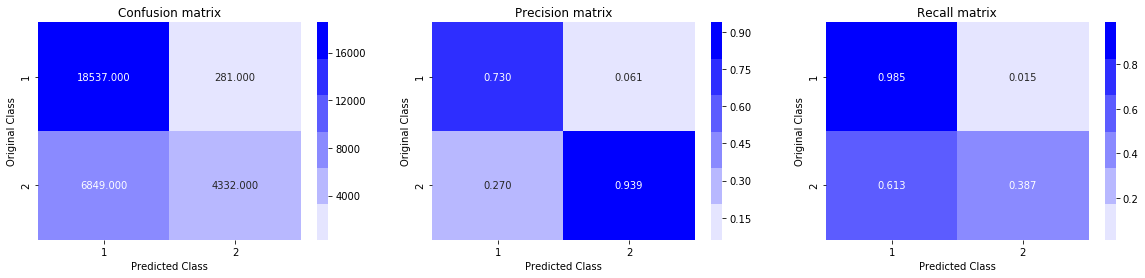

Time taken to run this cell:  7:25:41.483273


In [62]:
xgboost_fun(X_train_w2v,y_train_w2v,X_test_w2v,y_test_w2v)